In [35]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.models.spots import add_spots
from spice.plots import plot_3D
from spice.spectrum import simulate_observed_flux
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import TransformerPayne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from jax import vmap

# Large abundance spot

In this example, we will create a model of a star with a large Iron overabundance spot. This will provide a very nice example for changing line profiles. To obtain a good model of the line profiles, we need to use a precise model, so, as usual, we will use ```TransformerPayne```, and a higher-resolution model (>5000 mesh elements).

In [36]:
t = TransformerPayne.download()

m = IcosphereModel.construct(5000, 1., 1.,
                             t.to_parameters(),
                             t.stellar_parameter_names)

We can check the abundance of Iron, for future reference:

In [37]:
t.solar_parameters[t.stellar_parameter_names.index('Fe')]

7.45

In [38]:
from spice.models.utils import lat_to_theta, lon_to_phi, velocity_to_period

period_seconds = velocity_to_period(20., m.radius)
timestamps = jnp.linspace(0, period_seconds, 100)
mt = add_rotation(m, 20.)

SPOT_RADIUS = 90.

ms = add_spots(mt,
               spot_center_thetas=jnp.array([lat_to_theta(lat_deg) for lat_deg in [0]]),
               spot_center_phis=jnp.array([lon_to_phi(lon_deg) for lon_deg in [90]]),
               spot_radii=jnp.array([SPOT_RADIUS]),
               parameter_deltas=jnp.array([1.5]),
               parameter_indices=jnp.array([27]),
               smoothness=jnp.array([0.5]))

mts = [evaluate_rotation(ms, t) for t in tqdm(timestamps)]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3441.37it/s]


Let's plot the line-of-sight velocities and the Iron abundance map to inspect if the model is looking as intended.

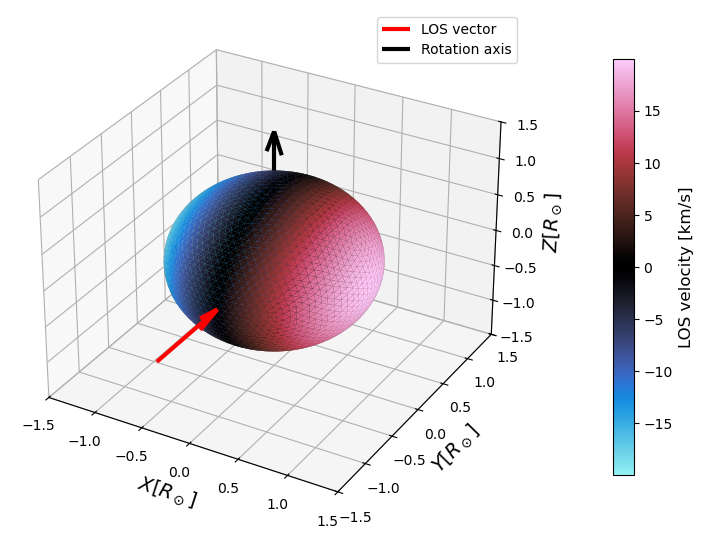

In [39]:
fig, _ = plot_3D(mts[0], 'los_velocities');

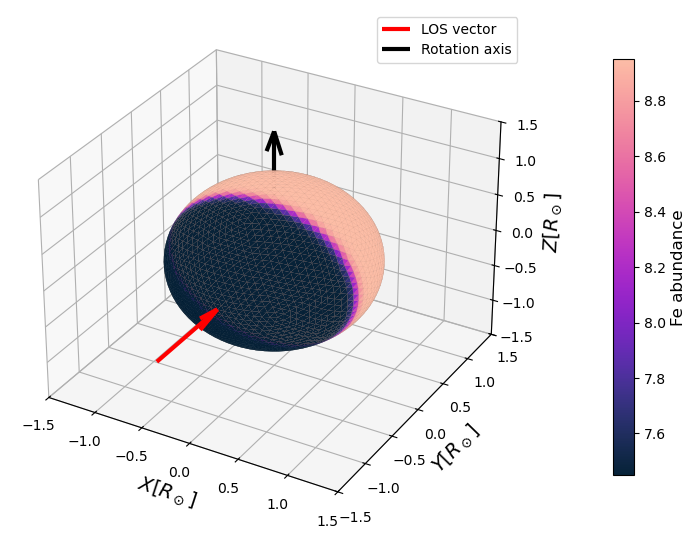

In [60]:
fig, _ = plot_3D(mts[0], 27, property_label='Fe abundance');
plt.savefig('large_iron_overabundance_spot_iron_abundance_map.svg', dpi=300)

Let's simulate a spectrum in a rather-narrow range of wavelengths, so that we obtain necessary precision.

In [41]:
vws = jnp.linspace(6064, 6068, 200)
spec = []
for mt in tqdm(mts):
    spec.append(simulate_observed_flux(t.intensity, mt, jnp.log10(vws)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:15<00:00,  4.35s/it]


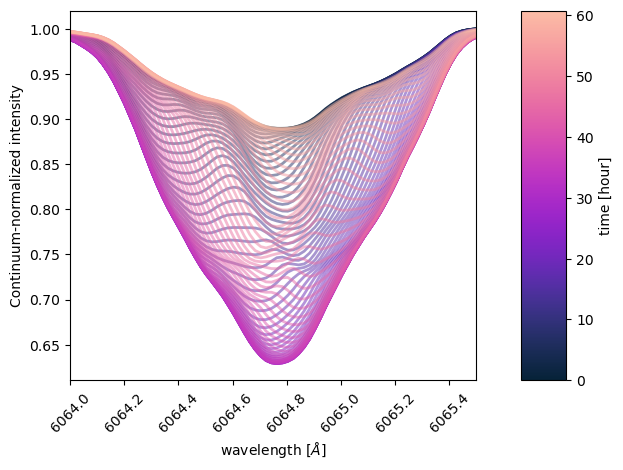

In [42]:
import matplotlib as mpl
import cmasher as cmr

fig, ax = plt.subplots(nrows=1, ncols=2, width_ratios=(9, 1))

n_lines = len(spec)
cmap = cmr.bubblegum

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

from scipy.ndimage import gaussian_filter1d

for s, c in zip(spec, colors):
    # Apply Gaussian smoothing to the spectrum
    smoothed_spectrum = gaussian_filter1d(s[:, 0]/s[:, 1], sigma=1)
    ax[0].plot(vws, smoothed_spectrum, color=c, alpha=0.5, linewidth=2)
    
ax[0].set_xlabel(r'wavelength [$\AA$]')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel('Continuum-normalized intensity');
ax[0].set_xlim(6064, 6065.5)

norm = mpl.colors.Normalize(vmin=timestamps[0]/3600, vmax=timestamps[-1]/3600)
cbar = ax[1].figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='cmr.bubblegum'),
            cax=ax[1], pad=.05);
cbar.set_label('time [hour]');
plt.savefig('large_iron_overabundance_spot_line_profile.svg', dpi=300)

As we can see, this Iron line is changing a lot, as expected!

## Gradients of spectra

Since ```JAX``` is differentiable, we can obtain a gradient of the computed spectra with respect to any parameter we wish. Let's try to synthesise spectra for some Iron abundances, and then calculate their gradients with respect to Iron.

We need to slightly rewrite the function to accomodate the way ```JAX``` expects functions to get gradients of. If we want to haver a gradient, we need to have a function which returns a single float value.

In [43]:
sp = jnp.array(t.to_parameters())
def intensity_for_fe_item(vw: float, fe: float):
    p = t.intensity(jnp.log10(jnp.array([vw])), 1.0, sp.at[27].set(fe))
    return p[0, 0]/p[0, 1]

def intensity_for_fe(vw: float, fe: float):
    p = t.intensity(jnp.log10(jnp.array([vw])), 1.0, sp.at[27].set(fe))
    return p[:, 0]/p[:, 1]

In [44]:
i = intensity_for_fe(vws[0], 1.0)
i

Array([0.9806021], dtype=float32)

Only now, we can convert the function (using ```JAX```'s ```vmap```) to a form which will allow us to calculate a full spectrum instead of singular intensity values for a singular wavelength.

In [45]:
spectrum_for_fe = vmap(intensity_for_fe, in_axes=(0, None))

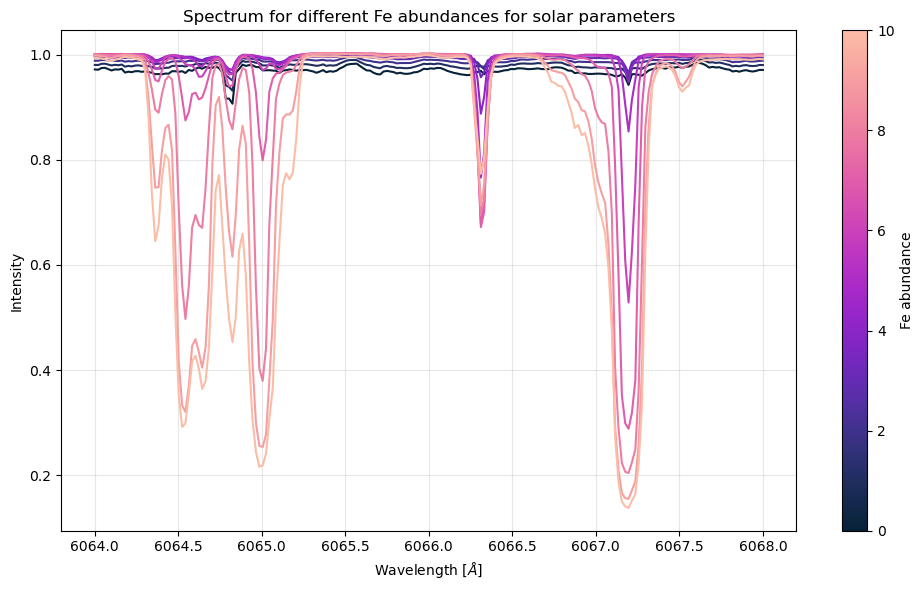

<Figure size 640x480 with 0 Axes>

In [46]:
# Define a range of Fe values to plot
fe_values = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]

# Create a figure with a main plot and space for a colorbar
fig, ax = plt.subplots(figsize=(10, 6))

# Get colors from the bubblegum colormap
cmap = cmr.bubblegum
colors = cmap(np.linspace(0, 1, len(fe_values)))

# Plot spectrum for each Fe value with assigned colors
for fe, color in zip(fe_values, colors):
    # Get the spectrum for this Fe value
    spectrum = spectrum_for_fe(vws, fe)
    # Plot with assigned color but no label
    ax.plot(vws, spectrum, color=color)

# Add labels
ax.set_xlabel(r'Wavelength [$\AA$]')
ax.set_ylabel('Intensity')
ax.set_title('Spectrum for different Fe abundances for solar parameters')
ax.grid(True, alpha=0.3)

# Create a colorbar
norm = mpl.colors.Normalize(vmin=min(fe_values), vmax=max(fe_values))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Fe abundance')

plt.tight_layout()
plt.show()
plt.savefig('large_iron_overabundance_spot_spectrum_for_different_fe_abundances.svg', dpi=300)

We can finally get the gradient of the function. We will receive a gradient of the intensity at a specific wavelength with respect to Iron.

In [47]:
import jax
grad_flux = jax.grad(intensity_for_fe_item, argnums=1)

In [48]:
grad_flux_spectrum = jax.vmap(lambda vw, fe: jnp.array([grad_flux(vw, fe)]), in_axes=(0, None))

In [49]:
# The error occurs because we're trying to use .item() with JAX tracers
# Let's modify our approach to avoid the ConcretizationTypeError

# First, let's redefine the intensity_for_fe_item function to not use .item()
def intensity_for_fe_item_fixed(vw: float, fe: float):
    p = t.intensity(jnp.log10(jnp.array([vw])), 1.0, sp.at[27].set(fe))
    return (p[:, 0]/p[:, 1])[0]  # Return the array instead of using .item()

# Now redefine the gradient function
grad_flux_fixed = jax.grad(intensity_for_fe_item_fixed, argnums=1)

# And redefine the vectorized version
grad_flux_spectrum_fixed = jax.vmap(lambda vw, fe: grad_flux_fixed(vw, fe), in_axes=(0, None))

# Test the fixed version
test_result = grad_flux_spectrum_fixed(vws, 1.0)
print(f"Shape of gradient result: {test_result.shape}")

Shape of gradient result: (200,)


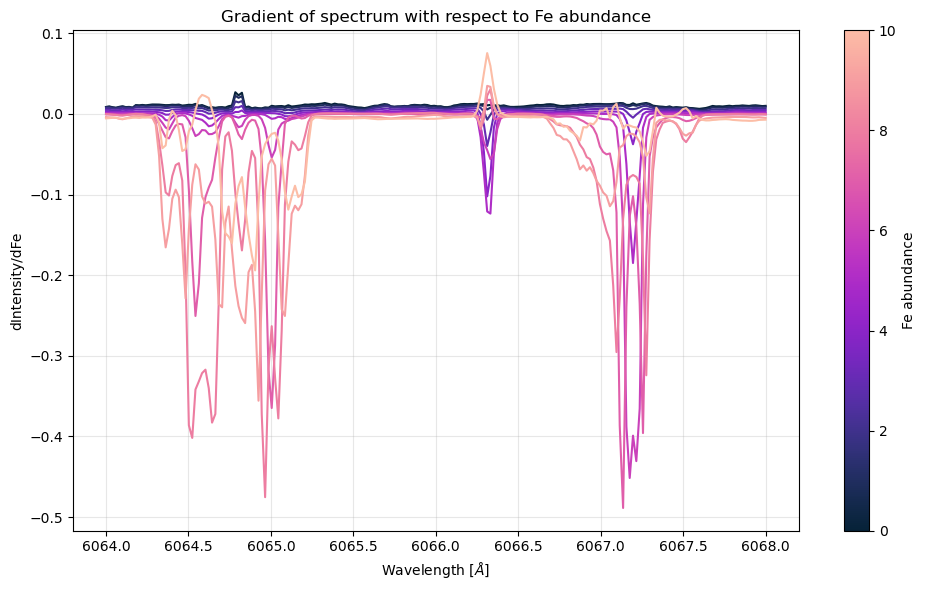

<Figure size 640x480 with 0 Axes>

In [50]:
# Define a range of Fe values to plot
fe_values = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap
cmap = cmr.bubblegum

# Plot gradient for each Fe value
for i, fe in enumerate(fe_values):
    # Get the gradient for this Fe value
    gradient = grad_flux_spectrum_fixed(vws, fe)
    # Plot with a color from the colormap based on fe value
    color = cmap(i / (len(fe_values) - 1))
    ax.plot(vws, gradient, color=color)

# Add labels
ax.set_xlabel(r'Wavelength [$\AA$]')
ax.set_ylabel('dIntensity/dFe')
ax.set_title('Gradient of spectrum with respect to Fe abundance')
ax.grid(True, alpha=0.3)

# Create a colorbar
norm = mpl.colors.Normalize(vmin=min(fe_values), vmax=max(fe_values))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Fe abundance')

plt.tight_layout()
plt.show()
plt.savefig('large_iron_overabundance_spot_gradient_of_spectrum_with_respect_to_fe_abundance.svg', dpi=300)

In [51]:
sm_ts = jnp.linspace(0, period_seconds, 5)
sm_mts = [evaluate_rotation(ms, t) for t in sm_ts]

In [52]:
LINE_NAMES = [
    'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Cr II', 'Fe II', 'Fe II'
]

def air_to_vacuum_wavelength(air_wavelength):
    # Edlén (1953) formula for conversion, valid for visible wavelengths
    sigma2 = (1e4 / air_wavelength)**2  # wavenumber squared, wavelength in Angstroms
    n = 1 + 0.0000834254 + 0.02406147/(130 - sigma2) + 0.00015998/(38.9 - sigma2)
    return air_wavelength * n

LINE_CENTERS_AIR = [
    5005.7122, 5006.1186, 5242.4907, 5263.3062, 5367.4659, 5383.3685, 5397.1279, 6146.1788, 6147.7341, 6149.2459
]
LINE_CENTERS = [air_to_vacuum_wavelength(lam) for lam in LINE_CENTERS_AIR]

In [53]:
line_vws = [np.linspace(LC-1, LC+1, 200) for LC in LINE_CENTERS]
line_specs = []

for i in tqdm(range(len(LINE_CENTERS))):
    line_specs.append([simulate_observed_flux(t.intensity, mt, jnp.log10(line_vws[i])) for mt in sm_mts])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:34<00:00, 21.47s/it]


<>:12: SyntaxWarning: invalid escape sequence '\A'
<>:12: SyntaxWarning: invalid escape sequence '\A'
/jobfs/148879072.gadi-pbs/ipykernel_394425/1957631575.py:12: SyntaxWarning: invalid escape sequence '\A'
  axs[i, 0].text(-0.6, 0.45, f'{LINE_CENTERS[i]} $\AA$', horizontalalignment='center', verticalalignment='center', transform=axs[i, 0].transAxes)


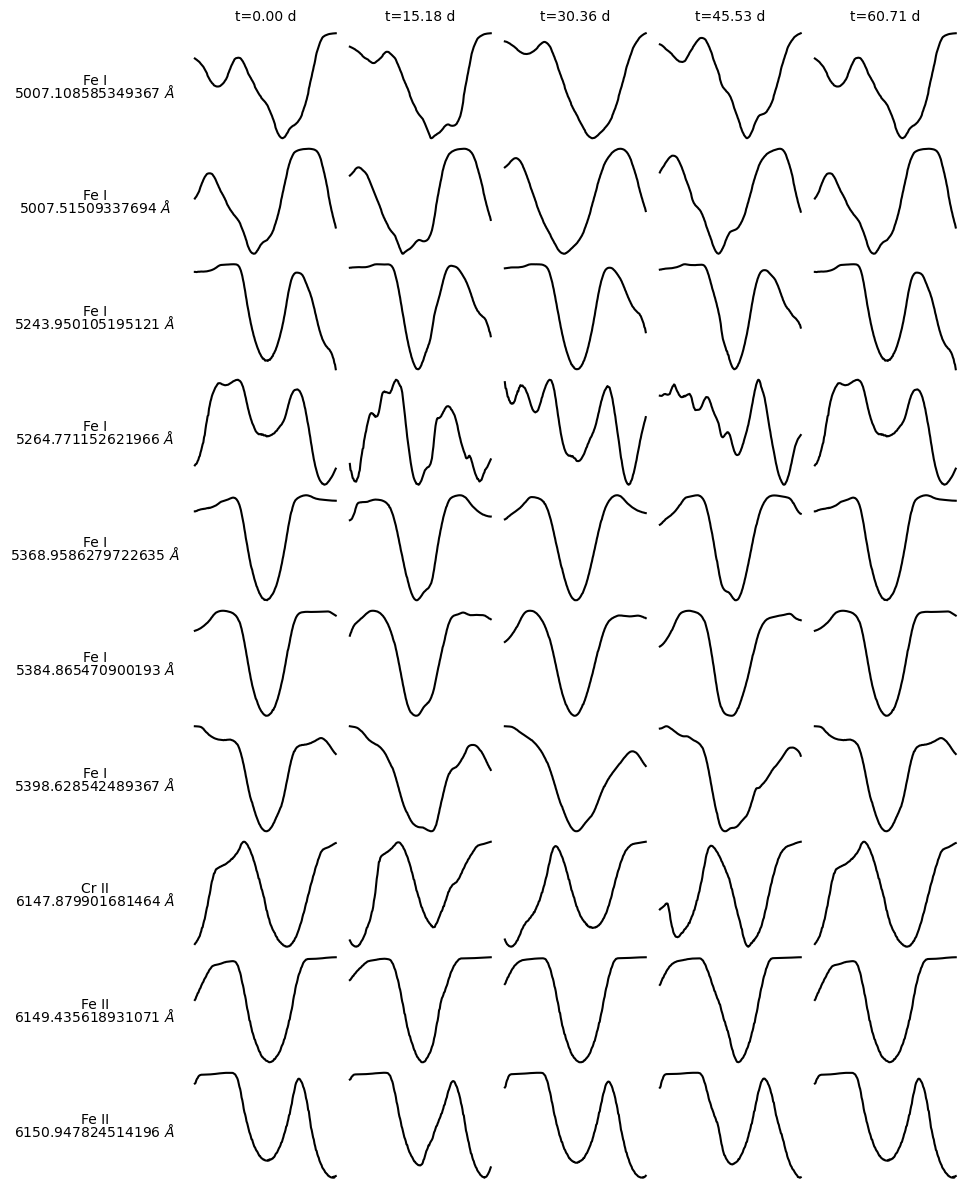

<Figure size 640x480 with 0 Axes>

In [59]:
fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(10, 15))

# Iterate over each subplot and remove the axes
for i in range(len(LINE_CENTERS)):
    for j in range(5):
        axs[i, j].axis('off')
        axs[i, j].plot(line_specs[i][j][:, 0]/line_specs[i][j][:, 1], color='black')

# Add annotations before each row
for i in range(len(LINE_CENTERS)):
    axs[i, 0].text(-0.6, 0.55, f'{LINE_NAMES[i]}', horizontalalignment='center', verticalalignment='center', transform=axs[i, 0].transAxes)
    axs[i, 0].text(-0.6, 0.45, f'{LINE_CENTERS[i]} $\AA$', horizontalalignment='center', verticalalignment='center', transform=axs[i, 0].transAxes)

# Add annotations above each column
for j in range(5):
    axs[0, j].text(0.5, 1.1, f't={sm_ts[j]/3600:.2f} d', horizontalalignment='center', verticalalignment='center', transform=axs[0, j].transAxes)

# Adjust layout
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()
plt.savefig('large_iron_overabundance_spot_line_profiles.svg', dpi=300)